In [1]:
using CellBasedModels
using GLMakie
# using CairoMakie
using Random
using CUDA
Makie.inline!(true);

In [2]:
include("physiCell.jl");
include("utils.jl");

# Functions

In [3]:
function setupPhysiCell!(com, parameters=PhysiCell.parameters; init_volumes=false, ratio_volume_target = 2, init_ratio=true)

    for p in keys(parameters)
        if p in keys(com.parameters)
            com[p] .= parameters[p]
        end
    end

    if !init_volumes && any(PhysiCell.f_v.(com.vF,com.vNS,com.vCS) .≈ 0.)
        print("WARNING. Some cells have volume zero. Maybe you forgot to set them up. Set `init_volumes=true` if you want automatically setting up them with default parameters.")
    elseif init_volumes
        com.vNS .= parameters[:vNSTarget]/ratio_volume_target
        com.vCS .= PhysiCell.f_vCSTarget(parameters[:fCN],com.vNS)/ratio_volume_target
        com.vF .= parameters[:fF]*parameters[:v]/ratio_volume_target
    end
    if init_ratio && :r in keys(com.parameters)
        com.r .= PhysiCell.f_r.(com.vF,com.vNS,com.vCS)
    end
    
end

setupPhysiCell! (generic function with 2 methods)

In [4]:
function plot_volume(com; size=(100,30), n=[1,2], stripe_size=5)

    d = getParameter(com,[:t,:id,:vF,:vCS,:vNS, :cycle])
    fig = Figure(size=size)
    ax = Axis(fig[1,1])
    for id in n
        ids = [id in i for i in d[:id]]
        pos = findfirst(d[:id][ids][1].==id)
        
        t = d[:t][ids]
        vNS = [i[pos] for i in d[:vNS][ids]]
        vCS = [i[pos] for i in d[:vCS][ids]]
        vF = [i[pos] for i in d[:vF][ids]]
        cycle = [i[pos] for i in d[:cycle][ids]]
        
        band!(ax,t,zeros(length(vNS)),vNS, color=:lightgreen)
        band!(ax,t,vNS,vNS.+vCS, color=:green)
        band!(ax,t,vNS.+vCS,vNS.+vCS.+vF, color=:orange)
        map = Dict(-1=>:gray,0=>:lightblue,1=>:blue,2=>:darkblue)
        band!(ax,t,-stripe_size .*ones(length(vNS)), 0 .*ones(length(vNS)), color=[map[i] for i in cycle])
    end

    return fig, ax
    
end

plot_volume (generic function with 1 method)

In [5]:
function plot_cells(com; times=[], show_ids=[], plane=[:x,:y], size=(400,400), alpha=(1,0.2,0.05), lims=nothing)

    if times == []
        times = [1, length(com)]
    end

    if show_ids == []
        show_ids = range(1,maximum(com.id))
    end
    
    d = getParameter(com,[:t,:x,:y,:z,:id,:vF,:vCS,:vNS])
    fig = Figure(size=(size[1],size[2]*length(times)))
    for (pos,time) in enumerate(times)
        if length(plane) == 2
            ax = Axis3(fig[pos,1], aspect = :data, azimuth=0.5*π, elevation=π/2, zlabelvisible=false, zticklabelsvisible=false)
        elseif length(plane) == 3
            ax = Axis3(fig[pos,1], aspect = :data)            
        else
            throw(Exception("Argument `plane` should be of size 2 or 3."))
        end
        ids = [i in show_ids for i in d[:id][time]]
        
        vNS = d[:vNS][time][ids]
        vCS = d[:vCS][time][ids]
        vF = d[:vF][time][ids]
        rN = PhysiCell.f_r.(vNS, 0., 0.)
        r = PhysiCell.f_r.(vNS, vCS, vF)
        x = d[plane[1]][time][ids]
        y = d[plane[2]][time][ids]
        rmax = maximum(r)

        if length(plane) == 2
            meshscatter!(ax, x, y, markersize=rN, color=(:black,alpha[1]))
            meshscatter!(ax, x, y, markersize=r, color=(:blue,alpha[2]))
            meshscatter!(ax, x, y, markersize=com.ra.*r, color=(:blue,alpha[3]))
        else
            z = d[plane[3]][time][ids]
            meshscatter!(ax, x, y, z, markersize=rN, color=(:black,alpha[1]))
            meshscatter!(ax, x, y, z, markersize=r, color=(:blue,alpha[2]))
            meshscatter!(ax, x, y, z, markersize=com.ra.*r, color=(:blue,alpha[3]))    
            if lims == nothing
                zlims!(ax, minimum(z)-com.ra[1]*rmax, maximum(z)+com.ra[1]*rmax)
            else
                zlims!(ax, lims[3,1], lims[3,2])#minimum(z)-com.ra[1]*rmax, maximum(z)+com.ra[1]*rmax)
        
            end
        end
        if lims == nothing
            xlims!(ax, minimum(x)-com.ra[1]*rmax, maximum(x)+com.ra[1]*rmax)
            ylims!(ax, minimum(y)-com.ra[1]*rmax, maximum(y)+com.ra[1]*rmax)
        else
            xlims!(ax, lims[1,1], lims[1,2])
            ylims!(ax, lims[2,1], lims[2,2])
        end
    end

    return fig
    
end

plot_cells (generic function with 1 method)

# Volume model & Cell Cycle models

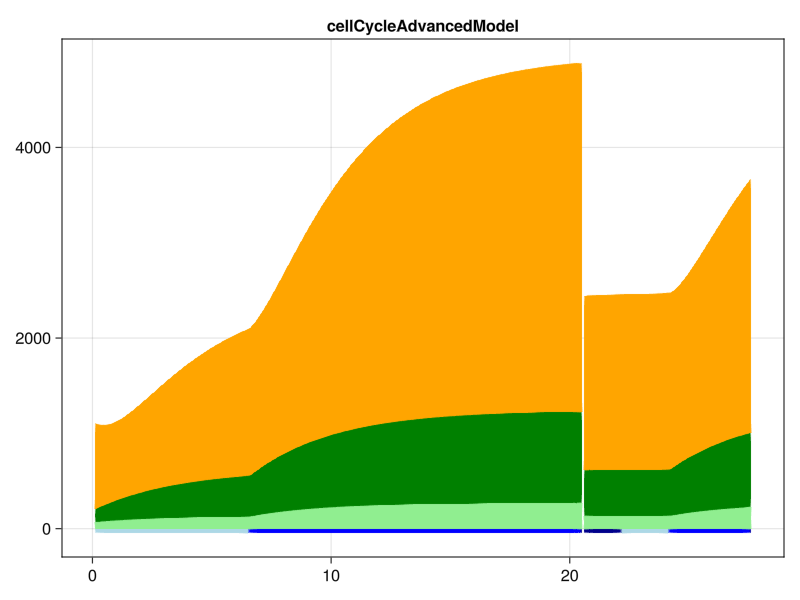

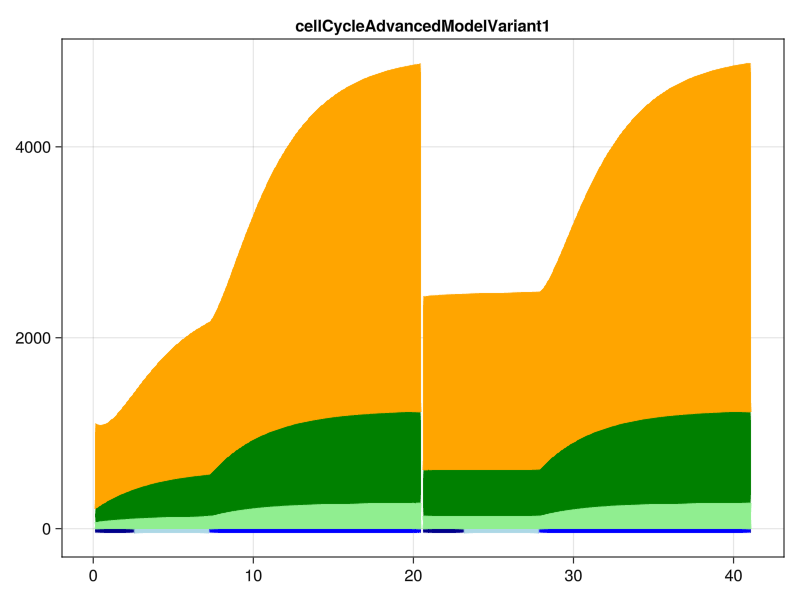

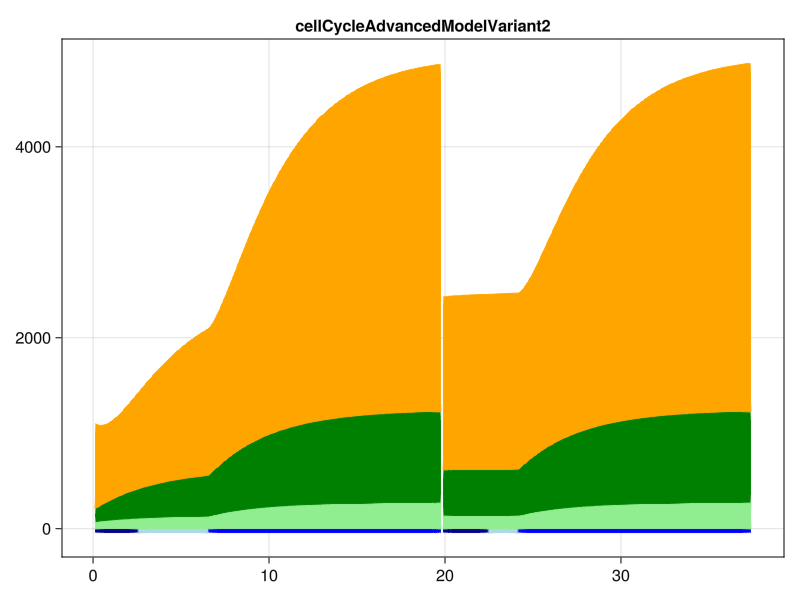

LoadError: BoundsError: attempt to access 0-element Vector{Vector{Int64}} at index [1]

In [6]:
for (name, cellCycleModel, cycle) in 
    [
        ("cellCycleAdvancedModel", PhysiCell.cellCycleAdvancedModel, 2),
        ("cellCycleAdvancedModelVariant1", PhysiCell.cellCycleAdvancedModelVariant1, 2),
        ("cellCycleAdvancedModelVariant2", PhysiCell.cellCycleAdvancedModelVariant2, 2),
        ("cellCycleBasicModel", PhysiCell.cellCycleBasicModel, 0),
        ("cellCycleBasicModelVariant1", PhysiCell.cellCycleBasicModelVariant1, 0),
        ("cellCycleBasicModelVariant2", PhysiCell.cellCycleBasicModelVariant2, 0),
        ("cellCycleLiveCellsModel", PhysiCell.cellCycleLiveCellsModel, 0),
    ]

    Random.seed!(0)
    model = ABM(3,
        baseModelInit = [
            PhysiCell.volumeModel,
            cellCycleModel,
            PhysiCell.cellDivisionModel
        ]
    );

    com = Community(model, N=1, dt=0.1)
    com.cycle = cycle
    setupPhysiCell!(com, init_volumes=true)

    evolve!(com, steps=500, preallocateAgents=9)
    com.N

    fig, ax = plot_volume(com, stripe_size=50)
    ax.title = name
    display(fig)

end

# Death Models

WARNING. Some cells have volume zero. Maybe you forgot to set them up. Set `init_volumes=true` if you want automatically setting up them with default parameters.

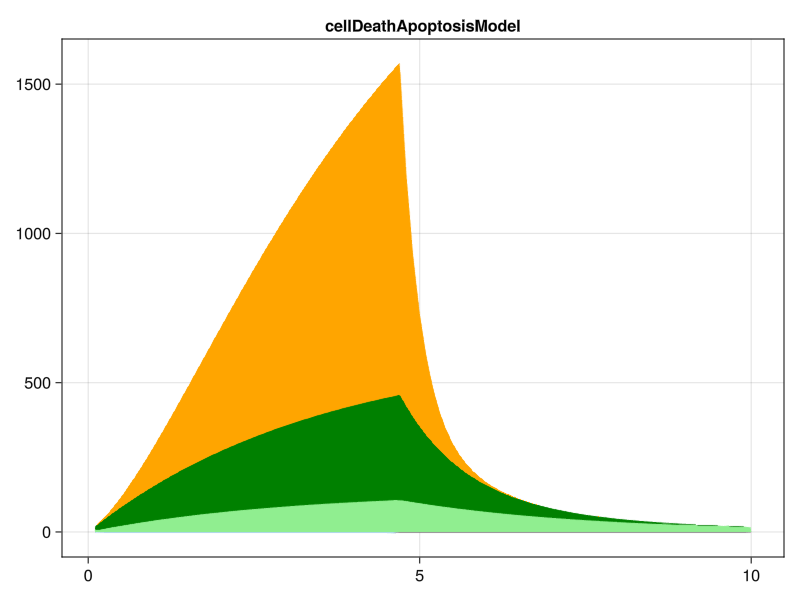

In [ ]:
for (name, cellDeathModel, cycle) in 
    [
        ("cellDeathApoptosisModel", PhysiCell.cellDeathApoptosisModel, 2),
    ]

    Random.seed!(0)
    model = ABM(3,
        baseModelInit = [
            PhysiCell.volumeModel,
            PhysiCell.cellCycleLiveCellsModel,
            PhysiCell.cellDivisionModel,
            cellDeathModel,
        ]
    );

    com = Community(model, N=1, dt=0.1)
    setupPhysiCell!(com)
    #Custom initialization    
    com.rDeathApop = 0.8
#    com.tApop = 100

    evolve!(com, steps=100, preallocateAgents=9)

    fig, ax = plot_volume(com, n=[1], stripe_size=5)
    ax.title = name
    display(fig)

end

# Mechanics

In [ ]:
include("physiCell.jl");
include("utils.jl");

## Cell interactions

In [ ]:
model = ABM(3,
    baseModelInit = [
        PhysiCell.volumeModel,
        PhysiCell.cellMechanicsModelBegin,
        PhysiCell.cellMechanicsCellCellAdhesionModel,
        PhysiCell.cellMechanicsModelEnd
    ]
);

In [ ]:
com = Community(model,N=2,dt=0.1/60)

setupPhysiCell!(com, init_volumes=true)
com.rF = 0
com.rC = 0
com.rN = 0

com.x .= [-4.,4.]
com.vF

2-element Vector{Float64}:
 935.25
 935.25

In [ ]:
evolve!(com, steps=2000, preallocateAgents=100)

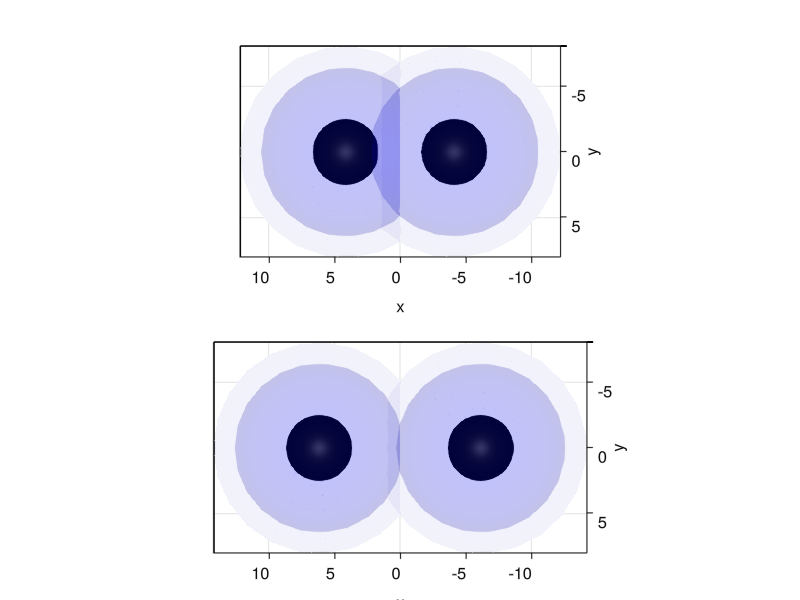

In [ ]:
plot_cells(com, plane=[:x,:y])

## Cell division

In [ ]:
model = ABM(3,
    baseModelInit = [
        PhysiCell.volumeModel,
        PhysiCell.cellCycleLiveCellsModel,
        PhysiCell.cellDivisionModel,
        PhysiCell.cellMechanicsModelBegin,
        PhysiCell.cellMechanicsCellCellAdhesionModel,
        PhysiCell.cellMechanicsModelEnd
    ],
    neighborsAlg=CBMNeighbors.CLVD(cellEdge=[10,10,10],skin=10,nMaxNeighbors=20),
    platform=GPU()
);

In [ ]:
com = Community(model,N=1,dt=0.1/60, simBox=[-300 300;-300 300;-300 300])

setupPhysiCell!(com, init_volumes=true)

1-element Vector{Float64}:
 6.450471028290378

In [ ]:
function evolveCustom!(com,steps,preallocateAgents)
    loadToPlatform!(com, preallocateAgents=preallocateAgents) #Always necessary to load the parameters to the platform
    t = time()
    @time for i in 1:steps
        step!(com) #Always necessary to update the parameters at the end of all the steps.
        if i % 1000 == 0
            println("Step ", i, " N: ",com.N, " Δt: ", time()-t)
            t = time()
        end
        if com.N >= preallocateAgents
            print(step)
            break
        end
    end
    saveRAM!(com)
    bringFromPlatform!(com) #Always necessary to bring the data back to RAM after evolution lo unlock the agent.
end;

In [ ]:
evolveCustom!(com, 200000, 100000)

Step 1000 N: 1 Δt: 0.5641839504241943
Step 2000 N: 1 Δt: 0.5565369129180908
Step 3000 N: 1 Δt: 0.5657880306243896
Step 4000 N: 1 Δt: 0.5764720439910889
Step 5000 N: 1 Δt: 0.5724680423736572
Step 6000 N: 1 Δt: 0.5626978874206543
Step 7000 N: 1 Δt: 0.5522599220275879
Step 8000 N: 1 Δt: 0.5583679676055908
Step 9000 N: 1 Δt: 0.5639560222625732
Step 10000 N: 1 Δt: 0.5585660934448242
Step 11000 N: 1 Δt: 0.5594310760498047
Step 12000 N: 1 Δt: 0.5703330039978027
Step 13000 N: 1 Δt: 0.571835994720459
Step 14000 N: 1 Δt: 0.5632140636444092
Step 15000 N: 1 Δt: 0.5800340175628662
Step 16000 N: 1 Δt: 0.5659630298614502
Step 17000 N: 1 Δt: 0.5622830390930176
Step 18000 N: 1 Δt: 0.5680990219116211
Step 19000 N: 2 Δt: 0.5621500015258789
Step 20000 N: 2 Δt: 0.5750589370727539
Step 21000 N: 2 Δt: 0.5763108730316162
Step 22000 N: 3 Δt: 0.554110050201416
Step 23000 N: 3 Δt: 0.5695791244506836
Step 24000 N: 3 Δt: 0.5630350112915039
Step 25000 N: 3 Δt: 0.5603630542755127
Step 26000 N: 3 Δt: 0.58072519302368

LoadError: InterruptException:

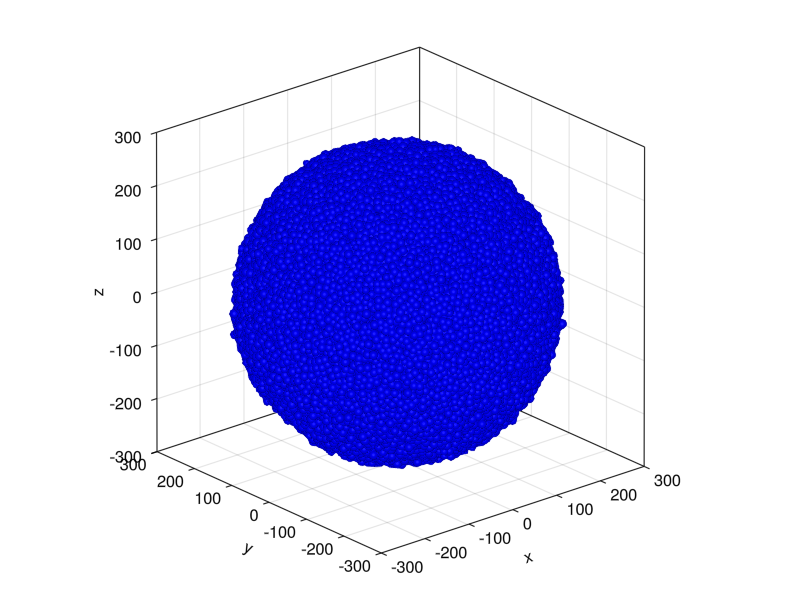

In [36]:
plot_cells(com, plane=[:x,:y,:z], alpha=(0,1,0), times=[1])

# Difussion

## Make veins

In [3]:
# Define the branching rules and grid
max_depth = 500
base_branch_length = 1.0
sparsity = 0.04  # Probability to generate a new branch
n_branches = 4
stop_ratio = 0.999
persistence = 0.7  # Persistence factor for branch direction

# Initialize the root point and direction
root_point = [50, 50, 0.0]
initial_direction = [0.0, 0.0, 1.0]

# Generate the fractal tree
Random.seed!(0)
nodes, edges = generate_fractal_tree(root_point, initial_direction, 0, 
    max_depth=max_depth, base_branch_length=base_branch_length, 
    sparsity=sparsity, persistence=persistence, n_branches=n_branches, stop_ratio=stop_ratio)

length(nodes)

6690

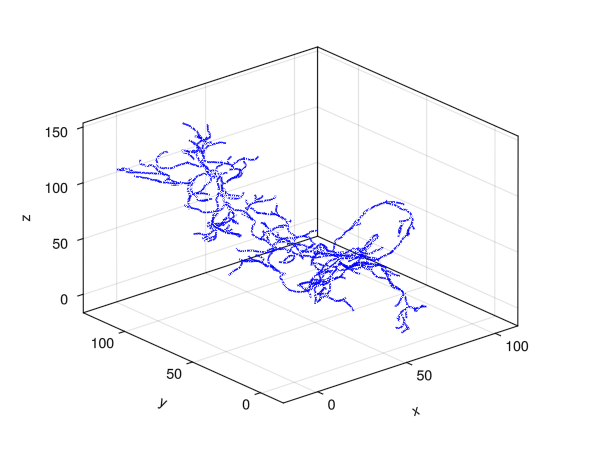

In [4]:
# Plot the tree using lines between nodes
f = Figure()
ax = Axis3(f[1,1])
for edge in edges
    p1, p2 = edge
    lines!(ax,[p1[1], p2[1]], [p1[2], p2[2]], [p1[3], p2[3]], color=:blue)
end

f

## Model

In [5]:
nsize=[100, 100, 100]
dt = 0.01
steps = 200

D = 10. ^ 5
dx = 10.
umax = 70.

70.0

In [6]:
model = ABM(3,

    model = Dict(
        :Dco2 => Float64,
        :λco2 => Float64,
        :co2saturation => Float64
    ),
    
    medium = Dict(
        :co2 => Float64,
        :veins => Float64
    ),

    mediumODE = quote

        if @mediumInside()            
            dt(co2) = veins*(co2saturation-co2)#-λco2*co2
        end        
    end,

    mediumAlg = CBMIntegrators.DGADI(difussionCoefs=(co2=:Dco2,)),

    platform = CPU()

);

In [7]:
function evolveCustom!(com,steps,preallocateAgents)
    loadToPlatform!(com, preallocateAgents=preallocateAgents) #Always necessary to load the parameters to the platform
    t = time()
    @time for i in 1:steps
        step!(com) #Always necessary to update the parameters at the end of all the steps.
        if i % 100 == 0
            println("Step ", i, " N: ",com.N, " Δt: ", time()-t)
            t = time()
        end
    end
    saveRAM!(com)
    bringFromPlatform!(com) #Always necessary to bring the data back to RAM after evolution lo unlock the agent.
end;

In [8]:
com = Community(model, dt=dt, simBox=[0 dx*nsize[1];0 dx*nsize[2];0 dx*nsize[3]], NMedium=nsize)
com.Dco2 = D
com.co2saturation = umax#70.
com.λco2 = 0.0#1

for (i,j,k) in nodes
    try
        com.veins[round(Int,i),round(Int,j),round(Int,k)] = 1.
    catch
        nothing
    end
end

In [9]:
evolve!(com,steps=steps,saveEach=steps)

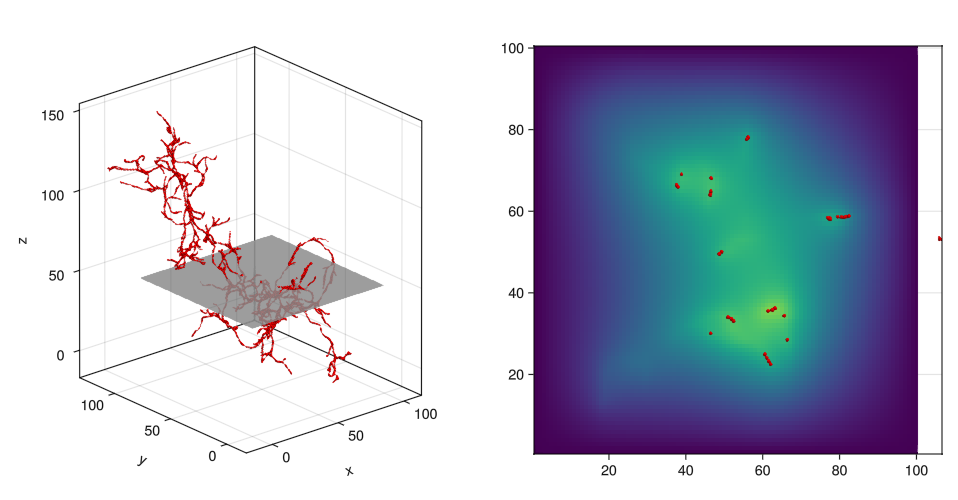

In [11]:
setMask(x) = x == 0 ? NaN : x

fig = Figure(size=(8000,500), backgroundColor=:lightgray, show_axis=false)

ax = Axis3(fig[1,1], aspect = :data)
#surface!(ax,[0,100,100,0],[0,100,0,100],ones(4)*50, color=:grey, alpha=1)
mesh!(ax, Rect3f(Point3f(0, 0, 50), Vec3f(100, 100, 0)), color = (:lightgray, 0.6), transparency=true)
# for edge in edges
#     p1, p2 = edge
#     scatterlines!(ax,[p1[1], p2[1]], [p1[2], p2[2]], [p1[3], p2[3]], color=:red, linewidth=1, linecap=:round)
# end
meshscatter!(ax,[i[1] for i in nodes],[i[2] for i in nodes],[i[3] for i in nodes],color=:red,markersize=0.5)
colsize!(fig.layout, 1, Aspect(1, 1))

ax = Axis(fig[1,2])
heatmap!(ax,com.co2[:,:,50], colorrange=(0,maximum(com.co2)))
meshscatter!(ax,[i[1] for i in nodes if round(Int,i[3])==50],[i[2] for i in nodes if round(Int,i[3])==50],color=:red,markersize=0.5)
#heatmap!(ax,setMask.(com.veins[:,:,50]), colorrange=(0,1), alpha=1, colormap=:reds)
colsize!(fig.layout, 2, Aspect(1, 1))

resize_to_layout!(fig)
fig